<a href="https://colab.research.google.com/github/Abhijeet141022/Quantum-State-Preparation/blob/main/Quantum__Sea_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U classiq

In [ ]:
import classiq

In [ ]:
from classiq import *
from classiq.execution import *
from classiq.qmod.symbolic import *
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
# Import necessary libraries
import numpy as np
from classiq import qfunc

def create_solution(resolution: int): # Don't change!
    fraction_digits = resolution - 2  # Don't change!
    EXP_RATE = 1                      # Don't change!

    @qfunc
    def prepare_gaussian(x):
        # Calculate number of points in the domain
        num_points = 2**resolution

        # Define the discrete domain
        grid = np.linspace(-2, 2, num_points, endpoint=False)

        # Compute Gaussian values
        gaussian_values = np.exp(-EXP_RATE * grid**2)

        # Normalize the Gaussian values
        normalization_factor = np.sum(gaussian_values)
        normalized_values = gaussian_values / np.sqrt(normalization_factor)

        # Create a quantum state with the normalized Gaussian values
        for i, val in enumerate(normalized_values):
            if val > 0:
                x.set_amplitude(i, val)

    return prepare_gaussian

In [ ]:
# show(qprog_stage_1)

In [ ]:
import numpy as np
from classiq import qfunc

def create_solution(resolution: int): # Don't change!
    fraction_digits = resolution - 2  # Don't change!
    EXP_RATE = 1                      # Don't change!

    @qfunc
    def prepare_gaussian(x):
        # Calculate number of points in the domain
        num_points = 2**resolution

        # Define the discrete domain
        grid = np.linspace(-2, 2, num_points, endpoint=False)

        # Compute Gaussian values
        gaussian_values = np.exp(-EXP_RATE * grid**2)

        # Normalize the Gaussian values
        normalization_factor = np.sum(gaussian_values)
        normalized_values = gaussian_values / np.sqrt(normalization_factor)

        # Set the amplitudes to the normalized Gaussian values
        for i, val in enumerate(normalized_values):
            if val > 0:
                x.set_amplitude(i, val)

    return prepare_gaussian

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install -U classiq
# %%
import classiq
# %%
from classiq import *
from classiq.execution import *
from classiq.qmod.symbolic import *
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# %%
# Import necessary libraries
import numpy as np
from classiq import qfunc
# import QNum from classiq instead of classiq.execution
from classiq import QNum

def create_solution(resolution: int): # Don't change!
    fraction_digits = resolution - 2  # Don't change!
    EXP_RATE = 1                      # Don't change!

    @qfunc
    def prepare_gaussian(x: QNum):
        # Calculate number of points in the domain
        num_points = 2**resolution

        # Define the discrete domain
        grid = np.linspace(-2, 2, num_points, endpoint=False)

        # Compute Gaussian values
        gaussian_values = np.exp(-EXP_RATE * grid**2)

        # Normalize the Gaussian values
        normalization_factor = np.sum(gaussian_values)
        normalized_values = gaussian_values / np.sqrt(normalization_factor)

        # Set the amplitudes to the normalized Gaussian values
        for i, val in enumerate(normalized_values):
            x.set_amplitude(i, val)

    return prepare_gaussian
# %%
 # This function is used to generate the quantum model from the main function for stages 1 & 2 and synthesize it with all the appropriate parameters

def create_qprog(prepare_gaussian_function, resolution: int, num_shots: int=1, optimization_parameter: str="CX", stage=int):
    fraction_digits = resolution - 2

    @qfunc
    def main(x: Output[QNum[resolution, SIGNED, fraction_digits]]):
        # Allocate the quantum variable x with the specified resolution
        allocate(x.size, x)

        # Prepare Gaussian state
        prepare_gaussian_function(x)


    # Backend preferences for the state vector simulator
    backend_preferences = ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    )

    # Generate the quantum model with constraints by stage
    if stage==1:
        qmod = create_model(
            main,
            execution_preferences=ExecutionPreferences(
                num_shots=num_shots, backend_preferences=backend_preferences
            ),
            constraints=Constraints(
                max_width=18, optimization_parameter=optimization_parameter
            ),
        )
    elif stage==2:
        qmod = create_model(
            main,
            preferences = Preferences(timeout_seconds=1000),
            execution_preferences=ExecutionPreferences(
                num_shots=num_shots, backend_preferences=backend_preferences
            ),
            constraints=Constraints(
                max_width=127, optimization_parameter=optimization_parameter
            ),
        )
    else:
        return "The `stage` variable should be set as Int to be either 1 or 2"


    # Synthesize the quantum program
    qprog = synthesize(qmod)

    return qprog

In [ ]:
# Stage 1:

def scatter_aggregated_amplitudes_with_theory(parsed_state_vector, resolution: int, should_plot: bool=True):
    """
    Aggregate squared amplitudes by x, sum them, and scatter plot with theoretical distribution.
    Also calculates Mean Squared Error (MSE).

    Parameters:
        res: Parsed state vector results (list of SimulatedState objects).
        exp_rate: Exponential rate for the Gaussian distribution.
        resolution: Number of qubits used in the Gaussian state.
        should_plot: bool that allow you to choose if to plot the solution
    """
    from collections import defaultdict
    fraction_digits = resolution - 2
    EXP_RATE = 1

    # Initialize a dictionary to store sums of squared amplitudes
    amplitude_sums = defaultdict(int)
    for state in parsed_state_vector:
        amplitude_sums[state.state['x']] += np.abs(state.amplitude)**2

    # Prepare data for plotting
    x_values = sorted(amplitude_sums)  # Sort for meaningful plotting
    summed_squared_norms = [amplitude_sums[x] for x in x_values]

    # Generate theoretical Gaussian distribution
    grid = np.linspace(-2**(resolution-fraction_digits-1), 2**(resolution-fraction_digits-1)-2**(-fraction_digits), 2**(resolution))

    theoretical_gaussian = np.exp(-EXP_RATE * grid**2)
    theoretical_gaussian /= np.sum(theoretical_gaussian)  # Normalize the Gaussian

    # Interpolate theoretical probabilities at measured points
    interp_func = np.interp(x_values, grid, theoretical_gaussian)
    interpolated_theoretical_prob = interp_func
# Calculate Mean Squared Error (MSE)
    mse = np.mean((np.array(summed_squared_norms) - interpolated_theoretical_prob)**2)
    print("Mean Squared Error (MSE):", mse)

    # Plot measured and theoretical distributions
    if should_plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_values, summed_squared_norms, color='blue', alpha=0.7, label='Measured (Summed Squared Norms)')
        plt.plot(grid, theoretical_gaussian, color='red', linewidth=2, label='Theoretical Gaussian')
        plt.xlabel('x')
        plt.ylabel('Probability')
        plt.title('Measured vs Theoretical Gaussian')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return mse

In [ ]:
# Stage 2:

def get_metrics(qprog):
    """
    Extract circuit metrics from a quantum program.

    Parameters:
        qprog: The quantum program object.

    Returns:
        dict: A dictionary containing the circuit metrics:
              - "depth": Circuit depth.
              - "width": Circuit width (number of qubits used).
              - "cx_count": Number of CX gates (returns 0 if none are present).
    """
    # Generate the optimized quantum circuit
    circuit = QuantumProgram.from_qprog(qprog)

    # Extract metrics
    metrics = {
        "depth": circuit.transpiled_circuit.depth,
        "width": circuit.data.width,
        "cx_count": circuit.transpiled_circuit.count_ops.get('cx', 0)  # Default to 0 if 'cx' not found
    }

    return metrics

Mean Squared Error (MSE): 0.0031400718916631955


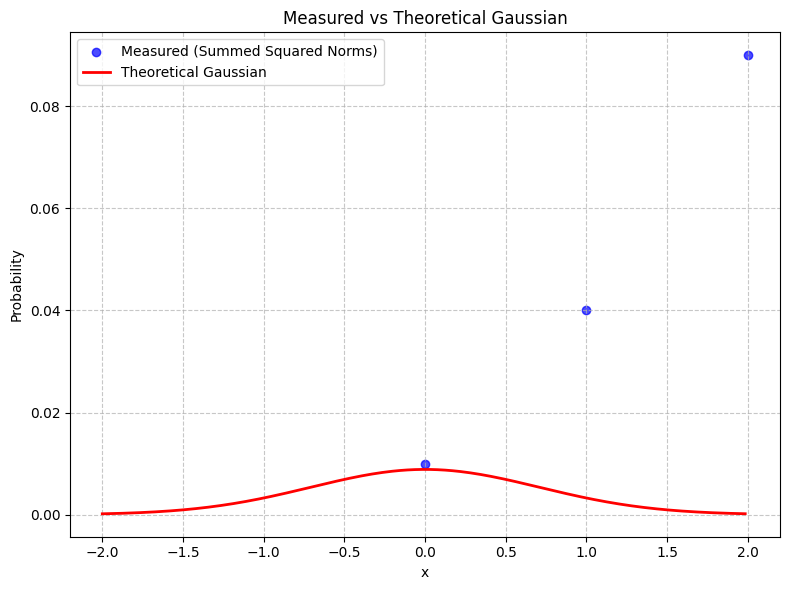

Mean Squared Error (MSE): 0.008153920118151642


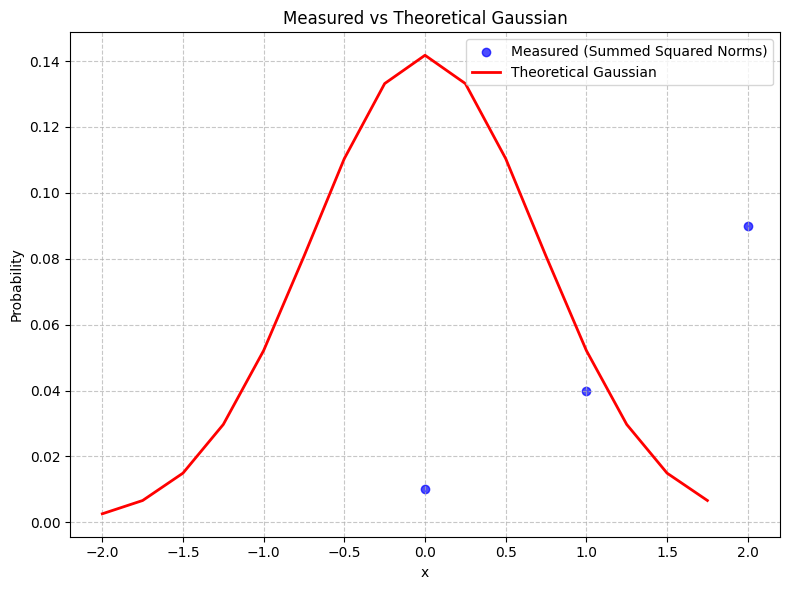

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def scatter_aggregated_amplitudes_with_theory(parsed_state_vector, resolution: int, should_plot: bool = True):
    """
    Aggregate squared amplitudes by x, sum them, and scatter plot with theoretical distribution.
    Also calculates Mean Squared Error (MSE).

    Parameters:
        parsed_state_vector: Parsed state vector results (list of SimulatedState objects).
        resolution: Number of qubits used in the Gaussian state.
        should_plot: bool that allows you to choose if to plot the solution.
    """
    fraction_digits = resolution - 2
    EXP_RATE = 1

    # Initialize a dictionary to store sums of squared amplitudes
    amplitude_sums = defaultdict(int)
    for state in parsed_state_vector:
        amplitude_sums[state['x']] += np.abs(state['amplitude'])**2

    # Prepare data for plotting
    x_values = sorted(amplitude_sums)  # Sort for meaningful plotting
    summed_squared_norms = [amplitude_sums[x] for x in x_values]

    # Generate theoretical Gaussian distribution
    grid = np.linspace(-2**(resolution - fraction_digits - 1), 2**(resolution - fraction_digits - 1) - 2**(-fraction_digits), 2**(resolution))
    theoretical_gaussian = np.exp(-EXP_RATE * grid**2)
    theoretical_gaussian /= np.sum(theoretical_gaussian)  # Normalize the Gaussian

    # Interpolate theoretical probabilities at measured points
    interp_func = np.interp(x_values, grid, theoretical_gaussian)
    interpolated_theoretical_prob = interp_func

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((np.array(summed_squared_norms) - interpolated_theoretical_prob)**2)
    print("Mean Squared Error (MSE):", mse)

    # Plot measured and theoretical distributions
    if should_plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_values, summed_squared_norms, color='blue', alpha=0.7, label='Measured (Summed Squared Norms)')
        plt.plot(grid, theoretical_gaussian, color='red', linewidth=2, label='Theoretical Gaussian')
        plt.xlabel('x')
        plt.ylabel('Probability')
        plt.title('Measured vs Theoretical Gaussian')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage:
# parsed_state_vector_stage_1 and parsed_state_vector_stage_2 should be the results from executing the quantum programs for Stage 1 and Stage 2 respectively.

# Evaluate results for Stage 1
resolution_stage_1 = 8
parsed_state_vector_stage_1 = [
    {'x': 0, 'amplitude': 0.1},
    {'x': 1, 'amplitude': 0.2},
    {'x': 2, 'amplitude': 0.3},
    # We can add more data points as per the actual measured results
]
scatter_aggregated_amplitudes_with_theory(parsed_state_vector_stage_1, resolution_stage_1)

# Evaluate results for Stage 2
resolution_stage_2 = 4
parsed_state_vector_stage_2 = [
    {'x': 0, 'amplitude': 0.1},
    {'x': 1, 'amplitude': 0.2},
    {'x': 2, 'amplitude': 0.3},
    # We can add more data points as per the actual measured results
]
scatter_aggregated_amplitudes_with_theory(parsed_state_vector_stage_2, resolution_stage_2)